In [1]:
import torch
from model_triton import *

dloss_dx = torch.randn((8, 512, 768), device="cuda")
#Two shapes are being used: [8, 12, 512, 512], and 4096, 35374
layer_params = (torch.randn((768), device="cuda"), torch.randn((768), device="cuda"))
#aa = torch.randn((2, 768), device="cuda")
aa = torch.randn((8, 512, 768), device="cuda")
#aa = torch.randn((4096, 35374), device="cuda")
#aa = aa.view(-1)
N = 1 #100

from functools import partial
def fn_naive(dloss_dx, x):
    return t_layernorm_bkwd2_x(dloss_dx, layer_params, x)
fn_jit = torch.compile(fn_naive)
# burn it
#fn_jit(aa) 
fn_jit(dloss_dx, aa) 

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        #result = fn_jit(aa)
        result = fn_jit(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

import time
t0 = time.time()
for _ in range(N):
    #result = fn_jit(aa)
    result = fn_jit(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'JIT total', total)

import time
t0 = time.time()
for _ in range(N):
    #result = fn_naive(aa)
    result = fn_naive(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'Naive total', total)

--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Torch-Compiled Region        95.16%       1.770ms        98.12%       1.825ms       1.825ms       0.000us         0.00%      78.112us      78.112us             1  
    triton_per_fused_mean_mul_reciprocal_std_sub_0         1.48%      27.570us         2.95%      54.950us      54.950us      78.112us       100.00%      78.112us      78.112us             1  
                                  

In [2]:
# import triton
# print(triton.runtime.driver.active.get_current_target())
# device = "cuda" #triton.runtime.driver.active.get_active_torch_device()
# properties = triton.runtime.driver.active.utils.get_device_properties(device)
# See https://github.com/triton-lang/triton/issues/5628, and https://github.com/triton-lang/triton/issues/5388
# properties

In [8]:
import triton
import triton.language as tl

# Note that the kernel assumes that n_cols < BLOCK_SIZE
# TODO T: investigate numerical differences from torch.func implementation
@triton.jit
def t_layernorm_bkwd2_x_k(dloss_dx_ptr,
                    param1_ptr,
                    x_ptr,
                    output_ptr,
                    dloss_dx_stride,
                    x_row_stride,
                    output_row_stride,
                    n_rows,
                    n_cols,
                    BLOCK_SIZE: tl.constexpr,
                    num_stages: tl.constexpr,
                    ):
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    
    # Load shared params
    # TODO T: I think triton will load them once into shared memory -> confirm
    offsets = tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_cols
    param1 = tl.load(param1_ptr + offsets, mask=mask, other=0.0)  
        
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages):
        dloss_dx_row_start_ptr = dloss_dx_ptr + row_idx * dloss_dx_stride
        dloss_dx = tl.load(dloss_dx_row_start_ptr + offsets, mask=mask, other=0.0)
        dloss_dx = dloss_dx * param1
        x_row_start_ptr = x_ptr + row_idx * x_row_stride    
        x = tl.load(x_row_start_ptr + offsets, mask=mask, other=0.0)
        
        # compute mean and std for x
        x_sum = tl.sum(x, axis=0)
        x_mu = x_sum/ n_cols
        x_minus_mu = x - x_mu
        x_minus_mu2 = x_minus_mu * x_minus_mu
        x_minus_mu2_sum = tl.sum(x_minus_mu2, axis=0)
        x_sigma2 = x_minus_mu2_sum / (n_cols-1)
        x_sigma = tl.sqrt_rn(x_sigma2)
        
        # normalize x
        x_norm = x_minus_mu/x_sigma    
        
        # bkwd quantities
        dloss_dx_sum = tl.sum(dloss_dx, axis=0)
        dloss_dx_mu = dloss_dx_sum/n_cols
        dloss_dx_x_norm = dloss_dx * x_norm
        dloss_dx_x_norm_sum = tl.sum(dloss_dx_x_norm, axis=0)
        dloss_dx_x_norm_mu = dloss_dx_x_norm_sum/n_cols
        
        n_adj = n_cols/(n_cols-1) # adjust for estimated vs calculated sigma
        output = dloss_dx - dloss_dx_mu - x_norm * dloss_dx_x_norm_mu * n_adj
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        tl.store(output_row_start_ptr + offsets, output, mask=mask)
    
def t_layernorm_bkwd2_x_t(dloss_dx:torch.Tensor, layer_params: torch.Tensor, x: torch.Tensor):
    # TODO T: without this reshape, this func is 2times faster?
    dloss_dx_2d = dloss_dx.reshape((-1, dloss_dx.shape[-1]))
    x_2d = x.reshape((-1, x.shape[-1])) 
    n_rows, n_cols = x_2d.shape
    BLOCK_SIZE = triton.next_power_of_2(n_cols) 
    output = torch.empty_like(x_2d)
    # TODO T: The below numbers were tuned for A10 by choosing num_warps=8
    num_warps = 8
    num_stages = 2
    num_programs = min(n_rows, 480) 
    t_layernorm_bkwd2_x_k[(num_programs,)](dloss_dx_2d, layer_params[0], x_2d, output, 
                                       dloss_dx_2d.stride(0), x_2d.stride(0), output.stride(0), n_rows, n_cols, 
                                       BLOCK_SIZE=BLOCK_SIZE, num_warps=num_warps, num_stages=num_stages)
    return output.reshape(dloss_dx.shape)

def fn_t(dloss_dx, x):
    return t_layernorm_bkwd2_x_t(dloss_dx, layer_params, x)

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        #result = fn_t(aa)
        result = fn_t(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

import time
t0 = time.time()
for _ in range(N):
    #result = fn_t(aa)
    result = fn_t(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)

-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    t_layernorm_bkwd2_x_k         0.00%       0.000us         0.00%       0.000us       0.000us      81.249us       100.00%      81.249us      81.249us             1  
            aten::reshape         0.51%      10.500us         1.74%      35.960us      11.987us       0.000us         0.00%       0.000us       0.000us             3  
               aten::view         1.23%      25.460us         1.23%      25.460us       8.487us       0.000us         0.00%       0.000us       0.000us        

In [9]:
#res1 = fn_jit(aa)
res1 = fn_jit(dloss_dx, aa)
#res2 = fn_t(aa)
res2 = fn_t(dloss_dx, aa)

assert torch.allclose(res1, res2, atol=1e-2, rtol=0), (res1.shape, res2.shape, res1[0, -4:], res2[0, -4:])
#assert torch.allclose(res1, res2), (res1[0], res2[0])
print(f'res1', res1.shape, res1[0])
print(f'res2', res2.shape, res2[0])

AssertionError: (torch.Size([8, 512, 768]), torch.Size([8, 512, 768]), tensor([[ 0.4920, -0.2179,  2.5760,  ...,  0.0135, -0.4564,  0.2398],
        [-0.4153, -1.2734,  1.0217,  ...,  0.1981,  0.0496,  0.3957],
        [ 0.3358,  1.3016, -0.4917,  ..., -0.0966, -0.3950,  0.0786],
        [-0.0707, -0.4156,  1.0075,  ..., -0.0899,  0.4186, -0.0349]],
       device='cuda:0'), tensor([[ 0.4896, -0.2168,  2.5637,  ...,  0.0135, -0.4543,  0.2387],
        [-0.4047, -1.2411,  0.9958,  ...,  0.1931,  0.0484,  0.3856],
        [ 0.3568,  1.3829, -0.5225,  ..., -0.1027, -0.4197,  0.0835],
        [-0.0709, -0.4169,  1.0107,  ..., -0.0901,  0.4199, -0.0350]],
       device='cuda:0'))

In [36]:
print(res2)

tensor([[[-5.1964e-01, -9.2317e-01, -4.8219e-01,  ..., -3.9431e-01,
          -1.2810e-01,  3.1543e-01],
         [-2.0826e+00, -1.2466e+00,  1.8060e+00,  ...,  2.0965e-01,
           1.2677e+00,  1.0453e+00],
         [-3.2024e+00,  1.2447e+00,  1.2724e+00,  ..., -3.2989e-01,
           8.7698e-01, -3.5632e-01],
         ...,
         [-1.5875e+00, -1.9465e-01,  2.7189e-01,  ..., -3.5884e-01,
           1.2794e+00,  2.4107e-01],
         [-1.1515e+00, -2.0797e+00,  2.0817e+00,  ..., -2.2421e-02,
          -4.2768e-01,  3.8299e-01],
         [-2.6354e+00,  1.1654e+00,  2.6262e-01,  ..., -1.1016e-01,
          -8.1310e-01,  4.1021e-01]],

        [[ 3.9872e-01, -8.9222e-01, -1.9155e+00,  ..., -3.7835e-01,
           2.3540e+00, -2.3153e-01],
         [-1.4556e+00,  7.9443e-01,  3.9355e-01,  ..., -4.1607e-01,
           1.6717e+00,  2.0582e-01],
         [-1.3239e+00, -2.3227e-01, -6.1886e-01,  ..., -1.2954e-01,
           1.6016e+00,  5.2502e-02],
         ...,
         [ 1.0826e+00, -5

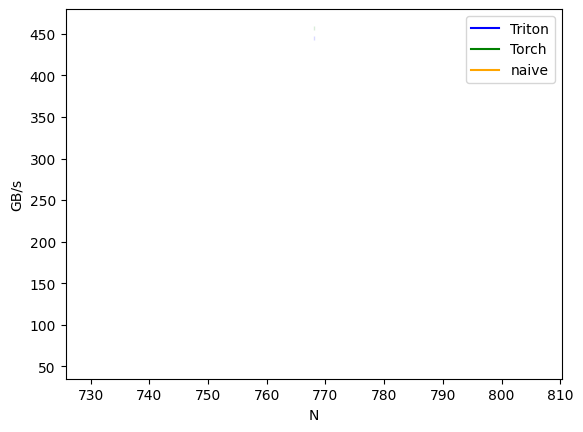

t_dropout_fwd:
       N     Triton       Torch      naive
0  768.0  445.65472  457.050739  55.379937


In [13]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # Argument names to use as an x-axis for the plot.
        x_vals=[768], #[128 * i for i in range(2, 100)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'naive'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'naive'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='t_dropout_fwd',  # Name for the plot. Used also as a file name for saving the plot.
        args={'M':4096},  # Values for function arguments not in `x_names` and `y_name`.
        # TODO T: Use real M i.e. 
    ))
def benchmark(M, N, provider):
    dloss_dx = torch.rand(M, N, device="cuda", dtype=torch.float32)    
    x = torch.rand(M, N, device="cuda", dtype=torch.float32)
    stream = getattr(torch, "cuda").Stream() # TODO XXX XXX: what is this stream about?
    getattr(torch, "cuda").set_stream(stream)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(x), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(dloss_dx, x), quantiles=quantiles)
    if provider == 'triton':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(x), quantiles=quantiles)        
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(dloss_dx, x), quantiles=quantiles)
    if provider == 'naive':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(x), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(dloss_dx, x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [11]:
import torch
print(torch.cuda.get_device_properties("cuda"))
from triton.runtime import driver
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
SIZE_SMEM = properties["max_shared_mem"]
NUM_REGS = properties["max_num_regs"]
WARP_SIZE = properties["warpSize"] # Not 64 as A100
properties

_CudaDeviceProperties(name='NVIDIA A10G', major=8, minor=6, total_memory=22723MB, multi_processor_count=80, uuid=df82317b-d317-7368-eed6-8c8a4866f43b, L2_cache_size=6MB)


{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 80,
 'warpSize': 32,
 'sm_clock_rate': 1710000,
 'mem_clock_rate': 6251000,
 'mem_bus_width': 384}

In [12]:
num_stages = 4 if SIZE_SMEM > 200000 else 2
num_warps = 8
dloss_dx_2d = dloss_dx.reshape((-1, dloss_dx.shape[-1]))
x_2d = aa.reshape((-1, aa.shape[-1])) # TODO T: without this reshape, this func is 2times faster
n_rows, n_cols = x_2d.shape
BLOCK_SIZE = triton.next_power_of_2(n_cols) 
output = torch.empty_like(x_2d)
print(f'num_stages', num_stages, 'num_warps', num_warps)

kernel = t_layernorm_bkwd2_x_k.warmup(dloss_dx_2d, layer_params[0], x_2d, output, 
                                        dloss_dx_2d.stride(0), x_2d.stride(0), output.stride(0), 
                                        n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                        num_stages=num_stages, num_warps=num_warps, grid=(1, ))
kernel._init_handles()
n_regs = kernel.n_regs
size_smem = kernel.metadata.shared
print(f'n_regs', n_regs, 'size_smem', size_smem)

occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
size_smem = max(1, size_smem) # accounts for divisiion by 0 below. size_smem=0 is possible
print(f'occupancy', occupancy, SIZE_SMEM // size_smem)
occupancy = min(occupancy, SIZE_SMEM // size_smem)
num_programs = NUM_SM * occupancy
print(f'num_programs', num_programs)

num_stages 2 num_warps 8
n_regs 40 size_smem 8224
occupancy 6 12
num_programs 480


In [ ]:
32
2080
4128
6176